### **Tính Toán Mô Hình Dịch Máy (Seq2Seq với RNN)**

Trong bài này, bạn sẽ thực hiện tính toán quá trình inference của mô hình dịch máy kiến trúc Encoder-Decoder như hình trên để dịch một câu từ tiếng Anh sang tiếng Việt. Bạn được cung cấp các thông tin sau:


Vocab của tiếng Anh và tiếng Việt với các token, index và embedding tương ứng:

<table>
<tr>
<td>

**Tiếng Anh:**

| Token  | Index | Embedding |
|--------|--------|-----------|
| `<eos>`| 0      | [ 1.9,  0.0] |
| `I`    | 1      | [-2.1,  0.5] |
| `love` | 2      | [-0.8, -1.0] |
| `you`  | 3      | [ 0.2,  0.6] |

</td>
<td>

**Tiếng Việt:**


| Token  | Index | Embedding |
|--------|--------|-----------|
| `<sos>`| 0      | [-2.7,  1.4] |
| `<eos>`| 1      | [ 0.1,  0.0] |
| `tôi`  | 2      | [ 1.5,  0.2] |
| `yêu`  | 3      | [ 2.2, -2.8] |
| `bạn`  | 4      | [-1.3,  0.1] |
| `anh`  | 5      | [ 1.0, -0.5] |
| `em`   | 6      | [ 0.0,  0.0] |

</td>
</tr>
</table>

### Kiến Trúc Mô Hình

- **Encoder:**  
  Nhận chuỗi các token tiếng Anh, đưa qua **Embedding** và sau đó qua RNN để tính toán hidden state tại mỗi bước.

- **Decoder:**
  - Sử dụng hidden state cuối cùng của encoder để khởi tạo.
  - Từng bước, nhận token đầu vào, đưa qua **Embedding**, tính hidden state mới qua RNN, sau đó qua lớp **Fully-Connected** để tính logits cho các token.
  - Áp dụng softmax lên logits để tính xác suất và chọn token có xác suất cao nhất.
  - Quá trình dừng khi gặp token `<eos>` hoặc sau 10 bước giải mã.

### Trọng Số Mô Hình

Dựa trên các trọng số đã cung cấp, dưới đây là bảng cập nhật với các giá trị chính xác, đã được làm tròn đến một chữ số thập phân:

| **Thành phần & Tham số**               | **Giá trị**                                                                                                                                                                                                                                                                                                                |
|----------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Trọng số Encoder RNN: Input-Hidden** | [ 0.5, 0.1 ],<br> [ -0.1, -0.2 ],<br> [ 0.6, 0.2 ]                                                                                                                                                                                                                                 |
| **Bias Encoder RNN: Input-Hidden**     | [ 0.8, -0.3, 0.1 ]                                                                                                                                                                                                                                                                 |
| **Trọng số Encoder RNN: Hidden-Hidden**| [ 0.1, 0.2, 0.2 ],<br> [ 0.2, 0.4, -0.5 ],<br> [ -0.1, -0.5, 0.0 ]                                                                                                                                                                                                                |
| **Bias Encoder RNN: Hidden-Hidden**    | [ -0.1, -0.5, 0.0 ]                                                                                                                                                                                                                                                               |
| **Trọng số Decoder RNN: Input-Hidden** | [ -0.7, 0.4 ],<br> [ -0.3, 0.9 ],<br> [ 0.6, -0.9 ]                                                                                                                                                                                                                               |
| **Bias Decoder RNN: Input-Hidden**     | [ 0.0, 1.0, 1.1 ]                                                                                                                                                                                                                                                                |
| **Trọng số Decoder RNN: Hidden-Hidden**| [ -0.1, -0.5, 0.8 ],<br> [ 0.6, 0.0, -0.3 ],<br> [ -1.2, 0.0, 0.0 ]                                                                                                                                                                                                             |
| **Bias Decoder RNN: Hidden-Hidden**    | [ -0.1, 0.5, 0.6 ]                                                                                                                                                                                                                                                                |
| **Trọng số Decoder FC Layer**          | [ 0.2, -0.9, -0.4 ],<br> [ 0.7, 0.7, 0.9 ],<br> [ 0.7, 0.9, -1.4 ],<br> [ -1.3, 1.2, 0.7 ],<br> [ -1.2, -1.3, 1.0 ],<br> [ 0.4, -1.1, -0.7 ],<br> [ -0.3, -0.6, -1.0 ]                                                                                                         |
| **Bias Decoder FC Layer**              | [ -1.1, 0.6, 0.5, 0.4, 0.4, -1.0, 0.0 ]                                                                                                                                                                                                    |




Với đầu vào là câu tiếng Anh **"I love you"**, bạn cần tính quá trình inference của mô hình để trả lời các câu hỏi:

## M08MT01
### Câu hỏi
Biết chiều của hidden state là 3. Tính hidden state $h_2$ của encoder (làm tròn đến 2 chữ số thập phân).

**Đáp án:** B

A. `[ 0.11 -0.4  0.25]`

B. `[-0.11 -0.4  -0.25]`

C. `[-0.4  -0.11  -0.25]`

D. `[ 0.11 -0.4  -0.25]`

## M08MT02
### Câu hỏi
Biết hidden state cuối cùng của Encoder $h_4 = [0.93, -0.89,  0.92]$. Hãy tính toán quá trình decode của mô hình và cho biết câu tiếng Việt được dự đoán bởi mô hình là gì?

**Đáp án:** D

A. `"tôi yêu em"`

B. `"anh yêu em"`

C. `"bạn yêu em"`

D. `"tôi yêu bạn"`


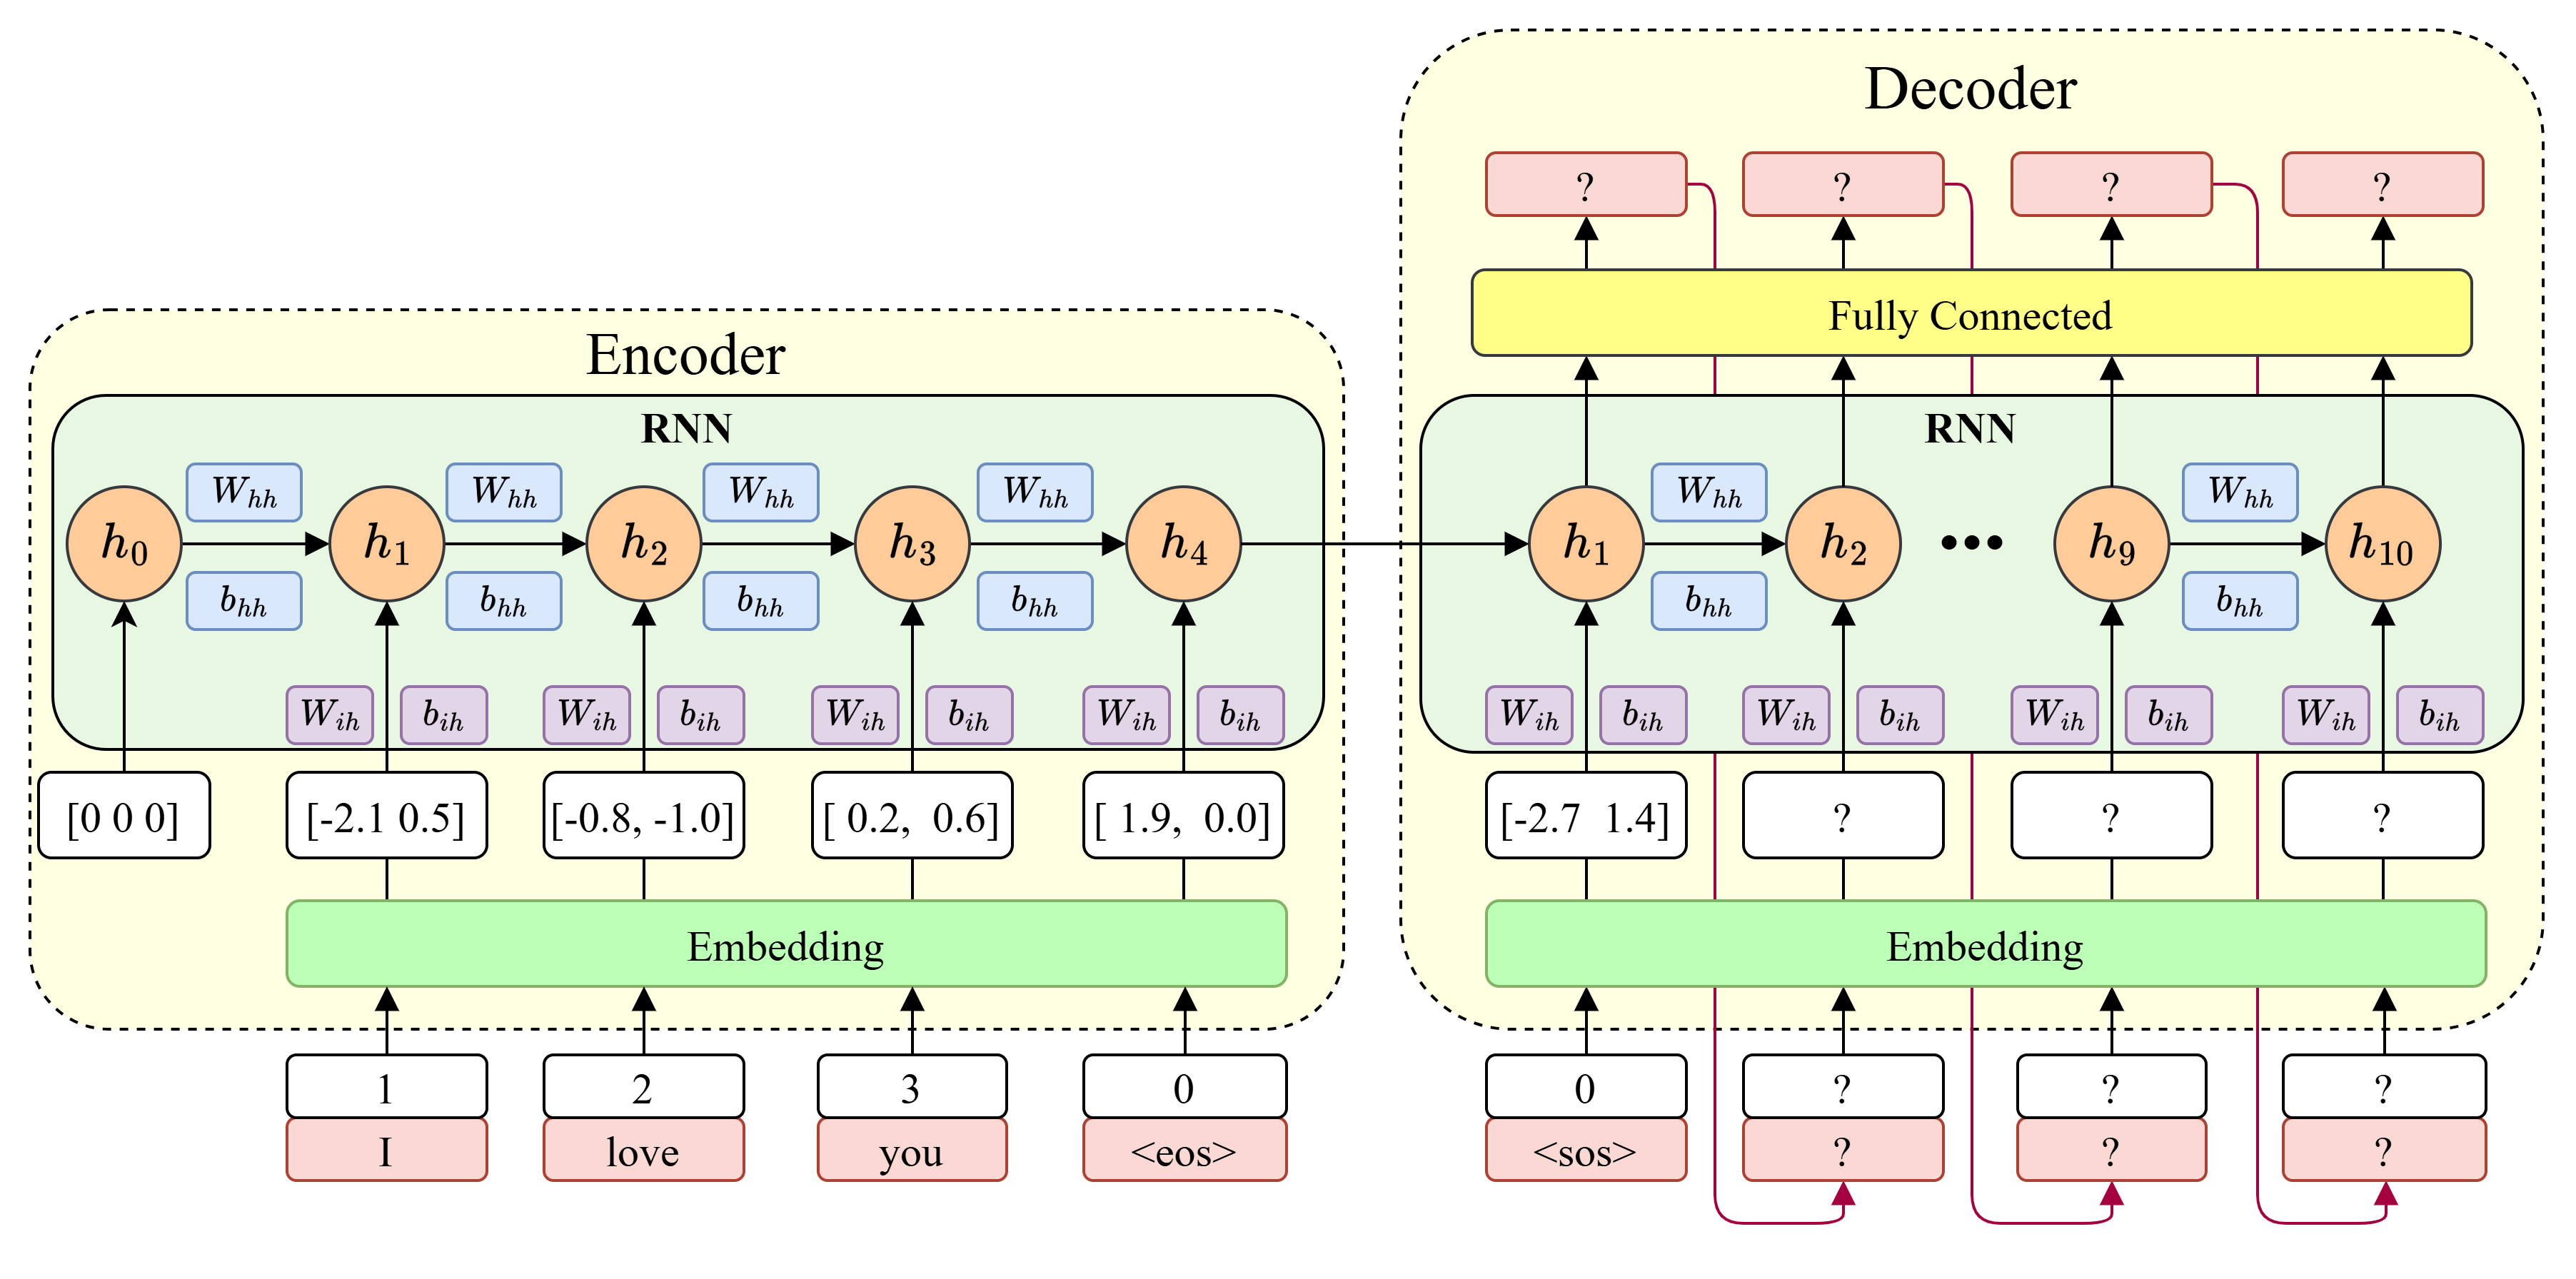

# Code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


### Set seed for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------
# 1. TIỀN XỬ LÝ DỮ LIỆU
# -----------------------

# Định nghĩa các token đặc biệt
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'

# Corpus cho tiếng Anh và tiếng Việt (chỉ một cặp câu)
corpus_en = ["I love you"]
corpus_vi = ["tôi yêu bạn", "anh yêu em"]

# Hàm tokenize: chuyển câu thành danh sách từ (chuyển về chữ thường)
def tokenize(sentence):
    return sentence.lower().split()

# Hàm xây dựng vocabulary: tạo từ điển cho các câu
def build_vocab(sentences):
    tokens = [token for sentence in sentences for token in tokenize(sentence)]
    if 'i' in tokens:
        vocab = {EOS_TOKEN: 0}
    else:
        vocab = {SOS_TOKEN: 0, EOS_TOKEN: 1}
    idx = len(vocab)
    for token in tokens:
        if token not in vocab:
            vocab[token] = idx
            idx += 1
    return vocab

vocab_en = build_vocab(corpus_en)
vocab_vi = build_vocab(corpus_vi)

print("Từ điển tiếng Anh:", vocab_en)
print("Từ điển tiếng Việt:", vocab_vi)

# Chuyển corpus thành dữ liệu dạng indices
data = []
for en, vi in zip(corpus_en, corpus_vi):
    src_indices = [vocab_en[token] for token in tokenize(en)] + [vocab_en[EOS_TOKEN]]
    trg_indices = [vocab_vi[SOS_TOKEN]] + [vocab_vi[token] for token in tokenize(vi)] + [vocab_vi[EOS_TOKEN]]
    data.append((src_indices, trg_indices))

print("Dữ liệu sau khi chuyển thành indices:", data)

Từ điển tiếng Anh: {'<EOS>': 0, 'i': 1, 'love': 2, 'you': 3}
Từ điển tiếng Việt: {'<SOS>': 0, '<EOS>': 1, 'tôi': 2, 'yêu': 3, 'bạn': 4, 'anh': 5, 'em': 6}
Dữ liệu sau khi chuyển thành indices: [([1, 2, 3, 0], [0, 2, 3, 4, 1])]


In [ ]:
# -----------------------
# 2. XÂY DỰNG CÁC LỚP MÔ HÌNH
# -----------------------

# Các tham số hyper-parameter
embedding_dim = 2  # Kích thước vector embedding (nhỏ để dễ tính tay)
hidden_size = 3    # Kích thước hidden state của RNN

# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)         # (batch_size, seq_len, embedding_dim)

        outputs, hidden = self.rnn(embedded)   # outputs: (batch_size, seq_len, hidden_size)
        return embedded, outputs, hidden       # Trả về embedding để phục vụ tính tay

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # x: (batch_size, 1) -> token hiện tại
        embedded = self.embedding(x)         # (batch_size, 1, embedding_dim)
        outputs, hidden = self.rnn(embedded, hidden)  # outputs: (batch_size, 1, hidden_size)
        predictions = self.fc(outputs)       # (batch_size, 1, output_size)
        return embedded, outputs, predictions, hidden

# --- Seq2Seq (gộp Encoder và Decoder) ---
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        # src: (batch_size, src_len), trg: (batch_size, trg_len)
        batch_size = src.size(0)
        trg_len = trg.size(1)
        output_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, trg_len, output_size).to(src.device)

        # Encoder forward
        _, _, hidden = self.encoder(src)

        # Khởi tạo đầu vào cho decoder với token <SOS>
        input_token = trg[:, 0].unsqueeze(1)  # (batch_size, 1)
        for t in range(1, trg_len):
            _, dec_output, fc_output, hidden = self.decoder(input_token, hidden)
            outputs[:, t, :] = fc_output.squeeze(1)
            input_token = trg[:, t].unsqueeze(1)
        return outputs

    def manual_inference(self, src, max_len=10):
        # Inference theo từng bước, in ra các giá trị trung gian
        embedded, _, hidden = self.encoder(src)
        print("Hidden state 2 của Encoder:", _[0][1].detach().numpy().round(2))
        print("Embedding encoder:", embedded.detach().numpy().round(2))
        input_token = torch.tensor([[vocab_vi[SOS_TOKEN]]]).to(src.device)
        print("Hidden state của Encoder:", hidden.squeeze(0).detach().numpy().round(2))
        tokens_list = []
        for t in range(max_len):
            emb, dec_output, fc_output, hidden = self.decoder(input_token, hidden)
            print(f"\n--- Decoder bước {t+1} ---")
            # In ra giá trị trung gian:
            current_token = list(vocab_vi.keys())[list(vocab_vi.values()).index(input_token.item())]
            print(f"Token đầu vào: '{current_token}'")
            print("Embedding của token:", emb.squeeze(0).detach().numpy().round(2))
            print("Hidden state (output của RNN):", dec_output.squeeze(0).detach().numpy().round(2))
            print("Đầu ra của FC (logits):", fc_output.squeeze(0).detach().numpy().round(2))
            probs = F.softmax(fc_output.squeeze(0), dim=1)
            print("Xác suất (softmax):", probs.detach().numpy().round(2))
            top1 = fc_output.argmax(2)
            predicted_token = list(vocab_vi.keys())[list(vocab_vi.values()).index(top1.item())]
            print("Dự đoán token:", predicted_token)
            if top1.item() == vocab_vi[EOS_TOKEN]:
                break
            tokens_list.append(top1.item())
            input_token = top1
        return tokens_list


In [ ]:
# Khởi tạo encoder, decoder và mô hình Seq2Seq
encoder = Encoder(len(vocab_en), embedding_dim, hidden_size)
decoder = Decoder(len(vocab_vi), embedding_dim, hidden_size)
model = Seq2Seq(encoder, decoder)

# -----------------------
# 3. HUẤN LUYỆN MÔ HÌNH
# -----------------------

num_epochs = 100
learning_rate = 0.01
weight_decay = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Huấn luyện trên corpus (chỉ 1 cặp câu)
for epoch in range(num_epochs):
    total_loss = 0
    for src_indices, trg_indices in data:
        src_tensor = torch.tensor(src_indices).unsqueeze(0)  # (1, seq_len_src)
        trg_tensor = torch.tensor(trg_indices).unsqueeze(0)    # (1, seq_len_trg)
        optimizer.zero_grad()
        outputs = model(src_tensor, trg_tensor)
        loss = 0
        for t in range(1, trg_tensor.size(1)):
            loss += criterion(outputs[:, t, :], trg_tensor[:, t])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(data)}")

# -----------------------
# LÀM TRÒN TRỌNG SỐ TRƯỚC INFERENCE
# -----------------------
def round_weights(model):
    with torch.no_grad():
        for param in model.parameters():
            param.copy_((param * 10).round() / 10)
round_weights(model)

# In ra trọng số của các layer – dữ liệu đề thi để thí sinh tính tay.
print("\n--- Trọng số của các layer sau huấn luyện ---")
print("Embedding Encoder:")
print(model.encoder.embedding.weight.data)

print("\nRNN weights Encoder (input-hidden):")
print(model.encoder.rnn.weight_ih_l0.data)
print("RNN bias Encoder (input-hidden):")
print(model.encoder.rnn.bias_ih_l0.data)

print("RNN weights Encoder (hidden-hidden):")
print(model.encoder.rnn.weight_hh_l0.data)
print("RNN bias Encoder (hidden-hidden):")
print(model.encoder.rnn.bias_hh_l0.data)

print("\nEmbedding Decoder:")
print(model.decoder.embedding.weight.data)

print("\nRNN weights Decoder (input-hidden):")
print(model.decoder.rnn.weight_ih_l0.data)
print("RNN bias Decoder (input-hidden):")
print(model.decoder.rnn.bias_ih_l0.data)
print("RNN weights Decoder (hidden-hidden):")
print(model.decoder.rnn.weight_hh_l0.data)
print("RNN bias Decoder (hidden-hidden):")
print(model.decoder.rnn.bias_hh_l0.data)

print("\nDecoder FC weights:")
print(model.decoder.fc.weight.data)
print("Decoder FC bias:")
print(model.decoder.fc.bias.data)

# -----------------------
# 4. HÀM INFERENCE VÀ TÍNH TAY (MANUAL INFERENCE)
# -----------------------
test_sentence = "I love you"
src_indices = [vocab_en[token] for token in tokenize(test_sentence)] + [vocab_en[EOS_TOKEN]]
src_tensor = torch.tensor(src_indices).unsqueeze(0)

print("\n=== Inference tính tay cho câu: '{}' ===".format(test_sentence))
predicted_tokens = model.manual_inference(src_tensor)
inv_vocab_vi = {idx: token for token, idx in vocab_vi.items()}
translated_sentence = ' '.join([inv_vocab_vi[idx] for idx in predicted_tokens])
print("\nCâu dịch dự đoán:", translated_sentence)

Epoch 20, Loss: 4.444774627685547
Epoch 40, Loss: 2.85526704788208
Epoch 60, Loss: 1.7109813690185547
Epoch 80, Loss: 1.1205101013183594
Epoch 100, Loss: 0.8089876174926758

--- Trọng số của các layer sau huấn luyện ---
Embedding Encoder:
tensor([[ 1.9000, -0.0000],
        [-2.1000,  0.5000],
        [-0.8000, -1.0000],
        [ 0.2000,  0.6000]])

RNN weights Encoder (input-hidden):
tensor([[ 0.5000,  0.1000],
        [-0.1000, -0.2000],
        [ 0.6000,  0.2000]])
RNN bias Encoder (input-hidden):
tensor([ 0.8000, -0.3000,  0.1000])
RNN weights Encoder (hidden-hidden):
tensor([[ 0.1000,  0.2000,  0.2000],
        [ 0.2000,  0.4000, -0.5000],
        [-0.1000, -0.5000,  0.0000]])
RNN bias Encoder (hidden-hidden):
tensor([-0.1000, -0.5000,  0.0000])

Embedding Decoder:
tensor([[-2.7000,  1.4000],
        [ 0.1000,  0.0000],
        [ 1.5000,  0.2000],
        [ 2.2000, -2.8000],
        [-1.3000,  0.1000],
        [ 1.0000, -0.5000],
        [ 0.0000,  0.0000]])

RNN weights Decoder 